In [ ]:
import random

In [ ]:
random_seed = 10
random.seed(random_seed)

In [ ]:
%pip install swifter
%pip install python-dotenv
%pip install bertopic
%pip install tensorflow
%pip install sentence-transformers
%pip install gensim

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import plotly.express as px
import matplotlib.pyplot as plt

from datetime import datetime
import logging
import os
import sys
import time
import re

from dotenv import load_dotenv
#import openai
import swifter
from sentence_transformers import SentenceTransformer


from bertopic import BERTopic
import joblib
from sklearn.preprocessing import normalize
from wordcloud import WordCloud

from gensim.models.phrases import Phrases, Phraser

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#shared drive version at everyone can set up
df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/palm_oil_grievance_logs.csv')
df.head(5)

,pk,source,internal_id,status,submitted_on,accepted_on,last_updated_on,country,region,complainants,respondents,respondent_sector,respondent_parent_company,respondent_supplier,summary,history,external_link,extras
0,1,Roundtable on Sustainable Palm Oil (RSPO),500Mg00000L0di6IAB,Closed,2/26/2025,4/15/2025,5/20/2025,Indonesia,Sumatera Selatan,Confidential,PT Sawit Mas Sejahtera,Oil Palm Growers,Golden Agri-Resources (GAR),NaN,That the Respondent allegedly transferred the ...,2025-05-20: CP's Decision Letter dated 20. 05....,https://rspo.my.site.com/Complaint/s/case/500M...,{'case_number': 'RSPO/2025/02/RR'}
1,2,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVwYqYAK,In Progress - Investigation,11/29/2024,1/16/2025,1/16/2025,Mexico,NaN,Confidential,INDUSTRIAS OLEOPALMA S.A. DE C.V.,Oil Palm Growers,Oleoquímica Mexicana S.A. de C.V.,NaN,The Complainant alleges that the Respondent ha...,2025-04-30: The Secretariat furnished the Resp...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/17/MAM'}
2,3,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVxmPYAS,In Progress - Investigation,11/28/2024,1/21/2025,1/21/2025,Colombia,Montes de María,Confidential,OLEOFLORES S A S,Processors and/or Traders,Musim Mas Holdings Pte.,NaN,1.The Complainant alleges that the Respondent ...,2025-04-30: The Complaints Panels directive to...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/18/HN'}
3,4,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVGg2YAG,In Progress - Investigation,10/16/2024,11/18/2024,11/18/2024,Indonesia,Riau,S. Samsul Hadi,PT Guntung Idamannusa,Oil Palm Growers,Compañía Industrial Aceitera Coto Cincuenta y ...,NaN,The Respondent's Corporate Social Responsibili...,2025-04-30: The Complaints Panel has directed ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/14/RH'}
4,5,Roundtable on Sustainable Palm Oil (RSPO),500GB00003vMwFgYAK,In Progress - Investigation,9/11/2024,10/29/2024,10/29/2024,Costa Rica,Pococi/Limón,Confidential,Compañía Palma Tica S.A.,Oil Palm Growers,NaN,NaN,The Complainant alleges that the Respondent br...,2025-04-30: The Briefing Note is in progress. ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/13/MAM'}


## Preprocessing

In [ ]:
#stop words, lower case, remove punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

#preprocessing
def clean_text(text):
    import re
    import string
    from nltk.corpus import stopwords

    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    tokens = text.split()

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word and word not in stop_words]

    return tokens

df["tokens"] = df["summary"].apply(clean_text)

bigram_model = Phrases(df["tokens"], min_count=5, threshold=100)
bigram_phraser = Phraser(bigram_model)

df["tokens_bi"] = df["tokens"].apply(lambda x: bigram_phraser[x])

words_to_filter = {'nan', 'pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community',
                   'complainants', 'companies', 'also', 'without', 'group', 'allegedly', 'period',
                   'respondent', 'reported', 'mentioned', '2019', '19', '2020', 'subsidary', 'alleges',
                   'respondent','Complainant','Final Countdown','report','Allegations','Greenpeace'
                   ,'GAR','MightyEarth','BHD','mighty_earth','green_peace','greenpeace','lands'}

df['flt_tokens'] = df["tokens_bi"].apply(lambda tokens: [word for word in tokens if word not in words_to_filter])



df = pd.DataFrame({'flt_tokens': df['flt_tokens'].apply(lambda x: ' '.join(x))})

## Embedding

In [ ]:
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level=logging.INFO)

BATCH_SIZE = 100
output_dir = "../data/intermediate"
os.makedirs(output_dir, exist_ok=True)

# load model once
model = SentenceTransformer('all-MiniLM-L6-v2')

# define embedding function
def get_embedding(text) -> list:
    if not text:
        return None
    try:
        return model.encode(text)
    except Exception as e:
        logging.error(f"Error getting embedding for text: {str(text)[:50]}... Error: {e}")
        return None

# main batch embedding function
def run_local_embeddings():
    formatted_datetime = datetime.now().strftime("%d_%b_%Y_%H_%M_%S")
    n = len(df)
    df['embedding'] = [None] * n

    df_start = 0
    while df_start < n:
        df_intermediate = df[df_start:df_start + BATCH_SIZE].copy()

        # Only process rows that do NOT have numpy array embeddings yet
        df_intermediate_unprocessed = df_intermediate.loc[
            df_intermediate['embedding'].apply(lambda x: not isinstance(x, np.ndarray))
        ]
        unprocessed_rows = len(df_intermediate_unprocessed)

        if unprocessed_rows == 0:
            logging.info(f"No unprocessed rows in batch starting at {df_start}")
        else:
            logging.info(f"Running embeddings on {unprocessed_rows} rows in batch starting at {df_start}")
            try:
                df_intermediate_unprocessed["embedding"] = df_intermediate_unprocessed["flt_tokens"].swifter.apply(
                    get_embedding
                )

                successful = df_intermediate_unprocessed.loc[
                    df_intermediate_unprocessed['embedding'].apply(lambda x: isinstance(x, np.ndarray))
                ]
                df.loc[successful.index, 'embedding'] = successful['embedding']

            except Exception as exc:
                logging.exception(f"Exception during embedding: {exc}")

        # save partial batch
        df.to_pickle(f"{output_dir}/embeddings_partial_{df_start}_{formatted_datetime}.pkl")
        df_start += BATCH_SIZE

    # save full dataset
    df.to_pickle(f"{output_dir}/embeddings_full_{formatted_datetime}.pkl")
    logging.info("Finished all batches and saved full dataset.")

run_local_embeddings()

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

## Model Creation

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [ ]:
%pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 3.1 MB/s eta 0:00:00


In [ ]:
from skfuzzy.cluster import cmeans
from sentence_transformers import SentenceTransformer
import umap
import numpy as np

In [ ]:
# # Define Clustering Models
# soft_kmeans_model = GaussianMixture(n_components=20, random_state=42)
class FuzzyCMeansModel:
    def __init__(self, n_clusters=6, m=2, error=0.005, maxiter=1000):
        self.n_clusters = n_clusters
        self.m = m
        self.error = error
        self.maxiter = maxiter
        self.labels_ = None
        self.centers = None
        self.u = None  # Membership matrix

    def fit(self, X):
        self.centers, self.u, _, _, _, _, _ = cmeans(
            X.T, self.n_clusters, self.m, error=self.error, maxiter=self.maxiter
        )
        self.labels_ = np.argmax(self.u, axis=0)
        return self

    def predict(self, X):
        return self.labels_

In [ ]:
## bertopic.py ##

# Filter out rows where the 'embedding' is None
df_embeddings = df.dropna(subset=['embedding']).copy()

# Normalize embeddings and store them in a new column
df_embeddings['embedding_normalized'] = df_embeddings['embedding'].apply(
  lambda x: normalize([x], norm='l2')[0]
)
embeddings_array = np.array(df_embeddings['embedding_normalized'].tolist())

# Use the cleaned text for docs
docs = df_embeddings['flt_tokens'].tolist()

# Initialize BERTopic model with a random_state for reproducibility

cluster_model = FuzzyCMeansModel(n_clusters= 6)
bertopic_model = BERTopic(hdbscan_model=cluster_model)

# Fit model
topics, probs = bertopic_model.fit_transform(docs, embeddings_array)

#fix for indexing, sotr the actual topic ids assigned by bert
df_embeddings["bertopic_topic"] = topics
df_embeddings["bertopic_prob"] = probs

# Get actual fuzzy topic probabilities from the Fuzzy C-Means model
membership_probs = cluster_model.u.T  # shape = (n_docs, n_topics)

# Turn it into a DataFrame
membership_df = pd.DataFrame(membership_probs, columns=[f"Topic_{i}" for i in range(cluster_model.n_clusters)])

# Join with df_embeddings
df_embeddings = df_embeddings.reset_index(drop=True)
df_embeddings = pd.concat([df_embeddings, membership_df], axis=1)

# Now you can access per-topic probabilities per document
df_embeddings.head()

df_embeddings["topic"] = membership_df.idxmax(axis=1).apply(lambda x: int(x.split("_")[1]))
df_embeddings["probs"] = membership_df.max(axis=1)


# Print the topics and their top words after fitting the model
print("BERTopic Topics and Top Words:")
print(bertopic_model.get_topics())

# Get the current datetime for the filename
formatted_datetime = datetime.now().strftime("%d_%b_%Y_%H_%M_%S")

# Create the output directory for embeddings if it doesn't exist
output_embeddings_dir = "../data/embeddings"
os.makedirs(output_embeddings_dir, exist_ok=True)

# Save dataframe with topics and probabilities
df_embeddings.to_csv(
  f"{output_embeddings_dir}/feedback_embeddings_bertopic_{formatted_datetime}.csv",
  index=False
)

# Create the output directory for models if it doesn't exist
output_models_dir = "../models"
os.makedirs(output_models_dir, exist_ok=True)

# save the model for future use on unseen data
joblib.dump(
  bertopic_model,
  f"{output_models_dir}/bertopic_model_{formatted_datetime}.joblib"
)

print("BERTopic model worked.")

BERTopic Topics and Top Words:
{0: [('gar', 0.07010015474849722), ('deforestation', 0.06389565743184464), ('agro', 0.03900668828121142), ('supplychain', 0.03098804626697301), ('rapidresponse', 0.030548832208658505), ('perkasa', 0.030084168547748785), ('linked', 0.026561182514548295), ('fire', 0.0261022506410577), ('supplier', 0.026074143449733363), ('ran', 0.02572084934536343)], 1: [('land', 0.09158055305959042), ('complainant', 0.05529250539885972), ('allegations', 0.03224186794510857), ('government', 0.025397612356714363), ('compensation', 0.024515580629684272), ('process', 0.02413626682913546), ('village', 0.021377812581707765), ('complaint', 0.020997021940991793), ('local', 0.02006730281050481), ('hgu', 0.019835640893387626)], 2: [('plasma', 0.04720790402362572), ('indonesia', 0.0420539673476576), ('area', 0.03901737447577297), ('village', 0.030110579159202767), ('permit', 0.02735704701001539), ('forest', 0.02594530130637738), ('land', 0.025529450878437707), ('papua', 0.02234694679

In [ ]:
df_embeddings['probs']

,probs
0,0.832096
1,0.750940
2,0.410913
3,0.281856
4,0.659704
...,...
382,0.355776
383,0.720967
384,0.921682
385,0.711821


In [ ]:
print(bertopic_model.get_topic_info())

   Topic  Count                                             Name  \
0      0     59             0_gar_deforestation_agro_supplychain   
1      1     53        1_land_complainant_allegations_government   
2      2     51                  2_plasma_indonesia_area_village   
3      3     50      3_concession_rapidresponse_ha_deforestation   
4      4     39  4_land_communities_principle_complainantalleges   
5      5     38           5_workers_dailycasual_employment_union   
6      6     28                 6_eof_plantation_gar_plantations   
7      7     25     7_clearance_peatlands_leuserecosystem_forest   
8      8     22                  8_products_ffb_cpo_nationalpark   
9      9     22         9_labour_rights_transnational_violations   

                                      Representation  \
0  [gar, deforestation, agro, supplychain, rapidr...   
1  [land, complainant, allegations, government, c...   
2  [plasma, indonesia, area, village, permit, for...   
3  [concession, rapidrespon

## Raw Output

In [ ]:
# Get the topic information DataFrame
topic_info_df = bertopic_model.get_topic_info()

#print(topic_info_df['Representation'])
# Iterate through the 'Representation' column and print each list of words
for index, representation in topic_info_df['Representation'].items():
    topic_id = topic_info_df.loc[index, 'Topic'] # Get the corresponding Topic ID
    print(f"Topic {topic_id} Representation: {representation}")

Topic 0 Representation: ['gar', 'deforestation', 'agro', 'supplychain', 'rapidresponse', 'perkasa', 'linked', 'fire', 'supplier', 'ran']
Topic 1 Representation: ['land', 'complainant', 'allegations', 'government', 'compensation', 'process', 'village', 'complaint', 'local', 'hgu']
Topic 2 Representation: ['plasma', 'indonesia', 'area', 'village', 'permit', 'forest', 'land', 'papua', 'forestry', 'hcv']
Topic 3 Representation: ['concession', 'rapidresponse', 'ha', 'deforestation', 'total', 'cleared', 'hectares', 'reportedindications', 'forests', 'forest']
Topic 4 Representation: ['land', 'communities', 'principle', 'complainantalleges', 'customary', 'newplanting', 'rspos', 'river', 'local', 'forest']
Topic 5 Representation: ['workers', 'dailycasual', 'employment', 'union', 'bpjs', 'termination', 'working', 'work', 'payment', 'complainant']
Topic 6 Representation: ['eof', 'plantation', 'gar', 'plantations', 'mill', 'forest', 'supplier', 'illegal', 'fruit', 'case']
Topic 7 Representation: [

In [ ]:
## bertopic.py ##

# Returns { topic_number: List[str] , ...}
rep_docs = bertopic_model.get_representative_docs()

rep_docs_df = pd.DataFrame.from_dict(rep_docs)
rep_docs_df.to_csv(
  f"../data/embeddings/representative_docs_{formatted_datetime}.csv",
  index=False
)

## Visualizations

In [ ]:
model_name = "LLM-BERTopic"

## Create Dataframe with Results

In [ ]:
import re
import pandas as pd

def format_bertopic_sentences(model, embeddings, n_topics):
    rows = []

    for index, row in embeddings.iterrows():
        doc_num = index
        dominant_topic = row['topic']
        topic_prob = row['probs']
        text = row['flt_tokens']

        # Topic contribution breakdown
        topic_dist = {f"Topic_{i}_Perc": 0.0 for i in range(n_topics)}
        topic_binary = {f"Topic_{i}_Indicate": 0 for i in range(n_topics)}

        shared_perc = 0.0
        dom_topic_num = dominant_topic if dominant_topic != -1 else None
        dom_topic_prob = topic_prob
        is_outlier = (dominant_topic == -1)
        itr = 0

        # Simulate topic breakdown via probability — if available
        if not is_outlier and isinstance(topic_prob, float):
            # Use the membership probabilities from the row if available
            for i in range(n_topics):
                topic_dist[f"Topic_{i}_Perc"] = round(row[f'Topic_{i}'] * 100, 2)
                if row[f'Topic_{i}'] > 0: # Indicate if there's any contribution
                    topic_binary[f"Topic_{i}_Indicate"] = 1

            shared_perc = topic_dist[f"Topic_{dominant_topic}_Perc"]
            dom_topic_num = dominant_topic
            itr = sum(list(topic_binary.values())) # Count number of topics with contribution
        else:
            # Optionally apply fallback logic for topic proportion
            topic_dist[f"Topic_{dominant_topic}_Perc"] = 100.0
            topic_binary[f"Topic_{dominant_topic}_Indicate"] = 1
            dom_topic_num = dominant_topic
            itr = 1

        # Keywords
        if dom_topic_num is not None and dom_topic_num != -1:
            keywords = ", ".join([word for word, _ in model.get_topic(row['bertopic_topic'])])
        else:
            keywords = "Outlier Topic"

        # Construct the document row
        row_data = {
            'Document_Num': doc_num,
            'Dominant_Topic': dom_topic_num,
            'Topic_%_Contrib': dom_topic_prob,
            'Topic_Keywords': keywords,
            'Text': text,
            'Is_Outlier': is_outlier,
            'Dom_Topics_Num': itr
        }
        row_data.update(topic_dist)
        row_data.update(topic_binary)
        rows.append(row_data)

    # Create DataFrame
    sent_topics_df = pd.DataFrame(rows)
    return sent_topics_df

In [ ]:
# This code adapts the LSA-based code to work with the BERTopic model.

# Ensure df_embeddings and bertopic_model are available
#if 'df_embeddings' not in locals() or 'bertopic_model' not in locals():
#    print("Error: 'df_embeddings' or 'bertopic_model' not found. Please run the data loading, embedding, and BERTopic modeling cells first.")
#else:
    # Create a list of dictionaries to hold the data for the new DataFrame
#    data = []

    # Iterate through the rows of df_embeddings
#    for index, row in df_embeddings.iterrows():
#        doc_num = index  # Use the original index as document number
#        dominant_topic = row['topic']
#        topic_prob = row['probs']
#        text = row['flt_tokens'] # Use flt_tokens as the 'Text'

        # Get the keywords for the dominant topic from the BERTopic model
        # bertopic_model.get_topic returns a list of (word, score) tuples
#        if dominant_topic != -1: # Exclude the outlier topic
#            keywords = ", ".join([word for word, score in bertopic_model.get_topic(dominant_topic)])
#        else:
#            keywords = "Outlier Topic" # Or handle outlier topic as needed

#        data.append({
#            'Document_Num': doc_num,
#            'Dominant_Topic': dominant_topic,
#            'Topic_%_Contrib': topic_prob,
#            'Keywords': keywords,
#            'Text': text
#        })

    # Create the DataFrame
#    df_dominant_topic = pd.DataFrame(data)

#    df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]

In [ ]:
df_embeddings

,flt_tokens,embedding,embedding_normalized,bertopic_topic,bertopic_prob,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,topic,probs
0,transferred complainant different department p...,"[-0.04253635, 0.04682076, 0.0356748, 0.0281250...","[-0.04253635138451751, 0.04682075928315759, 0....",5,None,0.012260,0.003449,0.003628,0.004817,0.009931,0.832096,0.007397,0.077952,0.021306,0.027164,5,0.832096
1,complainant_alleges unjustifiably dismissed wo...,"[-0.015173591, 0.08798484, 0.02648457, 0.05487...","[-0.01517358998232509, 0.08798483318633529, 0....",5,None,0.016792,0.004427,0.004696,0.006240,0.012474,0.750940,0.009552,0.121085,0.031476,0.042319,5,0.750940
2,1 complainant_alleges owns operates plantation...,"[0.0539281, 0.047474116, 0.013703154, -0.01478...","[0.0539281025497268, 0.04747411870773983, 0.01...",4,None,0.053845,0.007359,0.007872,0.011866,0.021313,0.033993,0.022029,0.087101,0.410913,0.343710,8,0.410913
3,corporate social responsibility csr program co...,"[-0.04023182, 0.052868072, -0.00653425, -0.022...","[-0.04023181855113276, 0.052868069782138385, -...",4,None,0.266077,0.017194,0.020128,0.038691,0.055776,0.025701,0.070300,0.064935,0.281856,0.159343,8,0.281856
4,complainant_alleges breached obligations ignor...,"[0.065631315, 0.051346518, 0.04964837, 0.02966...","[0.06563131784606244, 0.05134652023820672, 0.0...",4,None,0.045541,0.005961,0.006308,0.009907,0.018699,0.019618,0.020589,0.043933,0.659704,0.169740,8,0.659704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,rights violations land conflict sandabi indah ...,"[0.0027771199, 0.122810796, 0.00018314569, -0....","[0.002777119907427785, 0.12281079775111625, 0....",1,None,0.104707,0.010746,0.011370,0.016997,0.018809,0.041339,0.027208,0.280454,0.132593,0.355776,9,0.355776
383,rimba harapan saksti rhs sarana titian permata...,"[-0.047134, 0.03755123, -0.04950763, -0.064842...","[-0.04713400130643541, 0.037551232079399095, -...",2,None,0.720967,0.012555,0.013991,0.033098,0.016828,0.008869,0.063297,0.021287,0.061550,0.047558,0,0.720967
384,construction canal prepare deep forested peatl...,"[0.044433914, 0.06487626, 0.014453982, -0.0335...","[0.04443391362302665, 0.06487625764039853, 0.0...",7,None,0.005029,0.921682,0.040994,0.016724,0.002002,0.001268,0.004535,0.002027,0.003026,0.002713,1,0.921682
385,clearance potential high carbon stock hcs fore...,"[0.056225684, 0.09260251, 0.018626835, -0.0127...","[0.056225682559924314, 0.09260250466560725, 0....",7,None,0.028287,0.711821,0.100018,0.065368,0.011782,0.008128,0.027698,0.012648,0.017942,0.016308,1,0.711821


In [ ]:
# Assuming membership_df is available from the previous cell
# Get the number of topics from the membership_df columns (excluding original columns)
number_of_topics = len(membership_df.columns)

dominant_topic_df = format_bertopic_sentences(model=bertopic_model, embeddings=df_embeddings, n_topics=number_of_topics)

## Data Exploration

In [ ]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 7]

,Document_Num,Dominant_Topic,Topic_%_Contrib,Topic_Keywords,Text,Is_Outlier,Dom_Topics_Num,Topic_0_Perc,Topic_1_Perc,Topic_2_Perc,...,Topic_0_Indicate,Topic_1_Indicate,Topic_2_Indicate,Topic_3_Indicate,Topic_4_Indicate,Topic_5_Indicate,Topic_6_Indicate,Topic_7_Indicate,Topic_8_Indicate,Topic_9_Indicate
8,8,7,0.376191,"labour, rights, transnational, violations, tpo...",complainant_alleges affecting compliance act c...,False,10,4.83,0.98,1.05,...,1,1,1,1,1,1,1,1,1,1
52,52,7,0.355847,"labour, rights, transnational, violations, tpo...",complainant allegations subsidiaries located c...,False,10,5.46,0.99,1.06,...,1,1,1,1,1,1,1,1,1,1
120,120,7,0.428988,"labour, rights, transnational, violations, tpo...",complaint matter public interest taken complai...,False,10,2.76,0.67,0.71,...,1,1,1,1,1,1,1,1,1,1
206,206,7,0.883587,"labour, rights, transnational, violations, tpo...",3rd alert bulletin felda global ventures fgv c...,False,10,1.20,0.24,0.25,...,1,1,1,1,1,1,1,1,1,1
207,207,7,0.838231,"labour, rights, transnational, violations, tpo...",dian anggara persada dap violated worker freed...,False,10,1.54,0.34,0.36,...,1,1,1,1,1,1,1,1,1,1
235,235,7,0.485799,"labour, rights, transnational, violations, tpo...",sms worker head sbpks gsbi labour union dismis...,False,10,3.12,0.71,0.75,...,1,1,1,1,1,1,1,1,1,1
281,281,7,0.947313,"labour, rights, transnational, violations, tpo...",early july ahong kong based anti trafficking n...,False,10,0.54,0.11,0.11,...,1,1,1,1,1,1,1,1,1,1
288,288,7,0.885605,"labour, rights, transnational, violations, tpo...",transnational labour solidarity tpols said rec...,False,10,1.04,0.21,0.23,...,1,1,1,1,1,1,1,1,1,1
289,289,7,0.902740,"labour, rights, transnational, violations, tpo...",tpols stated transnational labour solidarity t...,False,10,0.93,0.18,0.19,...,1,1,1,1,1,1,1,1,1,1
290,290,7,0.769345,"labour, rights, transnational, violations, tpo...",tpols stated transnational labour solidarity t...,False,10,2.01,0.40,0.43,...,1,1,1,1,1,1,1,1,1,1


## Wordcloud

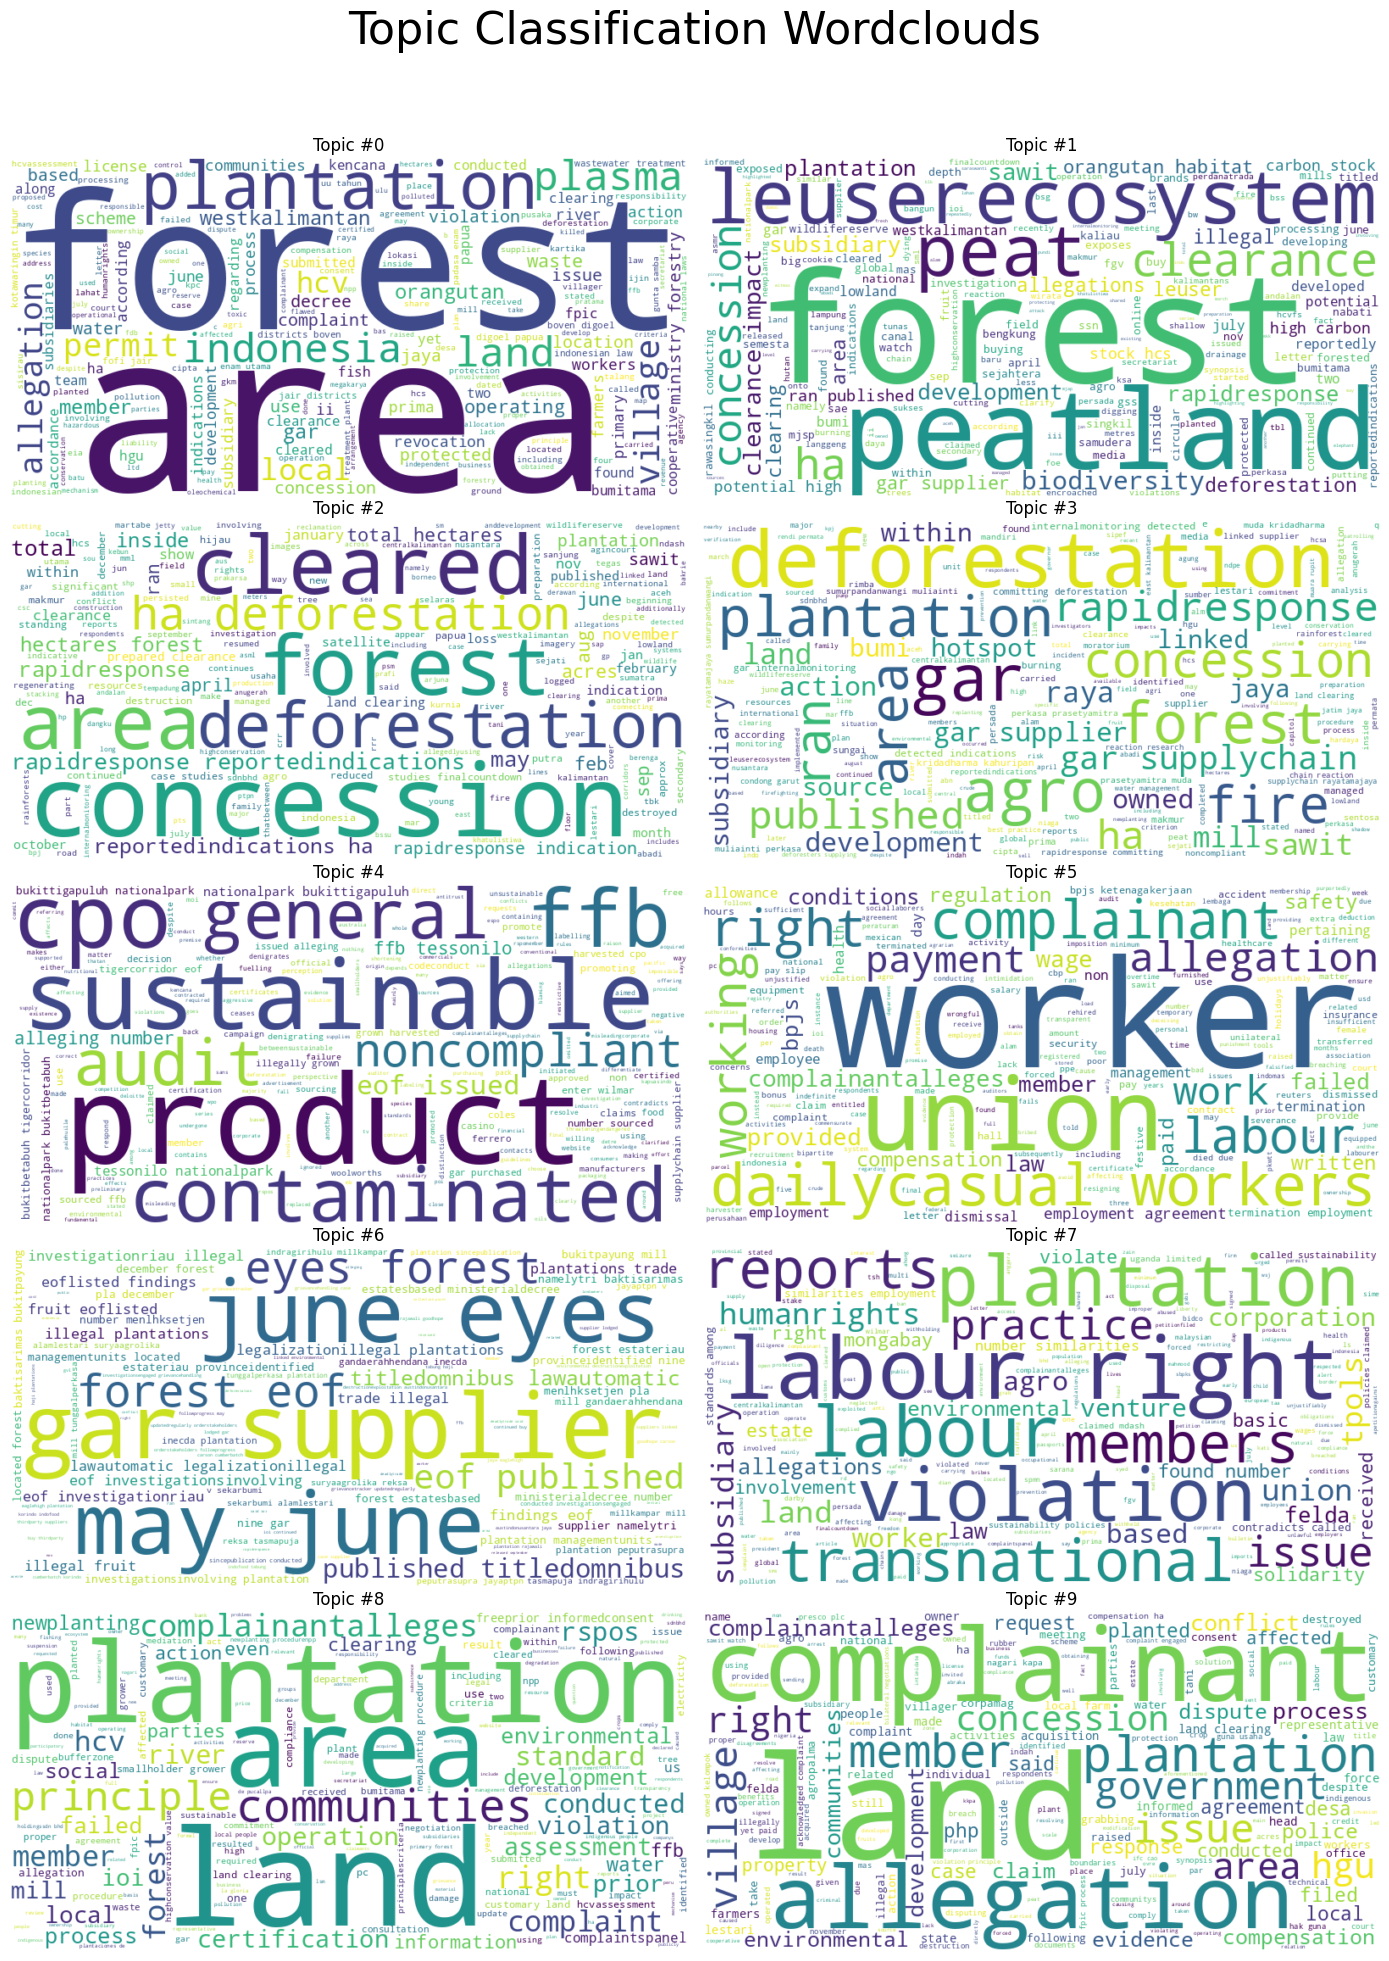

In [ ]:
# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(14, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = df[df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    # Fix: Convert words_to_filter set to a list before concatenation
    en_stop = set(stopwords.words('english') + list(words_to_filter))
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=dominant_topic_df, title='Topic Classification Wordclouds', n_topics=6)

## Dominant Topic Frequency

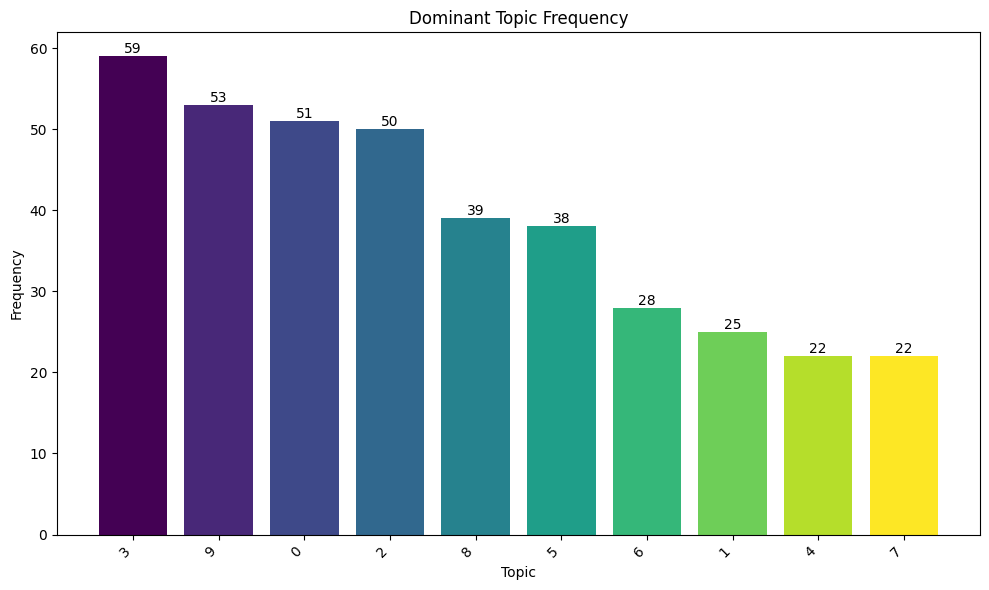

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # Import numpy if not already imported

# Ensure df_dominant_topic is available
if 'dominant_topic_df' not in locals():
    print("Error: 'dominant_topic_df' not found. Please run the cell that creates dominant_topic_df first.")
else:
    # Calculate topic share (frequency) from df_dominant_topic
    df_topic_share = dominant_topic_df.groupby(['Dominant_Topic'])['Document_Num'].count().reset_index()
    df_topic_share.columns = ['Topic', 'Frequency'] # Rename columns for clarity

    # Sort by frequency to potentially make the plot more informative
    df_topic_share = df_topic_share.sort_values('Frequency', ascending=False)


    # Define colors (optional, adjust as needed based on number of topics)
    # Ensure the number of colors matches the number of topics to display
    num_topics_to_plot = len(df_topic_share)
    # You can use a colormap to generate enough colors
    colors = plt.cm.viridis(np.linspace(0, 1, num_topics_to_plot))


    # Create the bar plot
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjust figure size as needed

    # Plot the bars
    bars = ax.bar(df_topic_share['Topic'].astype(str), df_topic_share['Frequency'], color=colors)

    # Add labels to the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

    # Set plot title and labels
    plt.title('Dominant Topic Frequency')
    plt.xlabel('Topic')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels if they overlap
    plt.tight_layout() # Adjust layout
    plt.show()

## Topic Distribution per Doc

In [ ]:
def topic_dist_doc(df, n_topics, doc_num):
    import matplotlib.pyplot as plt

    topics = []
    values = []

    doc_row = df[df['Document_Num'] == doc_num]

    for i in range(n_topics):
        col_name = f"Topic_{i}_Perc"
        val = doc_row[col_name].values[0] if not doc_row.empty and pd.notnull(doc_row[col_name].values[0]) else 0.0
        topics.append(col_name)
        values.append(float(val))  # Ensure it's a float

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(topics, values, color='red')
    plt.xlabel('Topics')
    plt.ylabel('Topic Contribution')
    plt.title(f'{model_name} - Topic Distribution for Document {doc_num}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

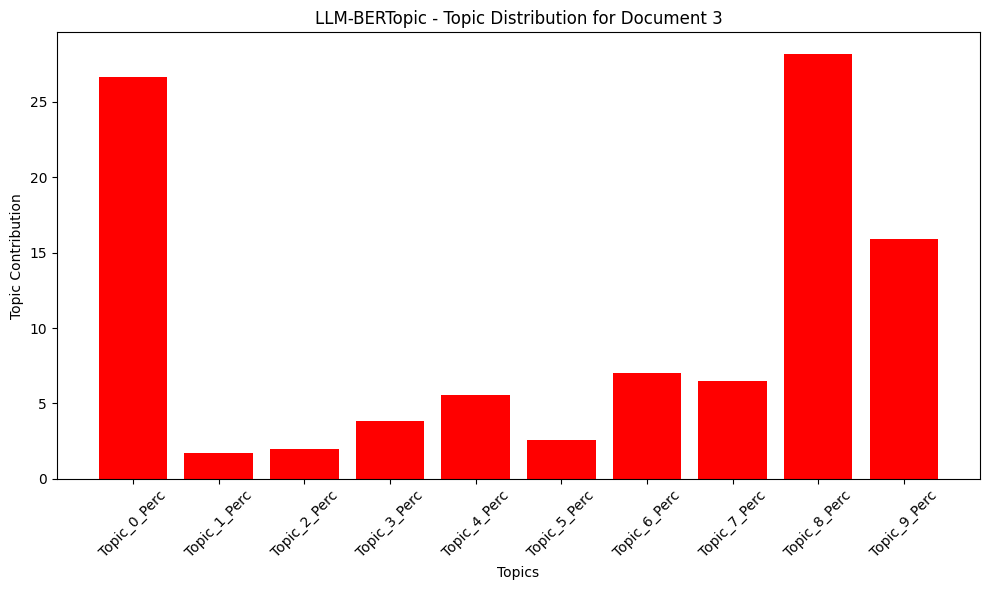

In [ ]:
doc_number = 3    # Change This
topic_dist_doc(dominant_topic_df, number_of_topics, doc_num=doc_number)

## Scoring Methods

## Topic Coherence Score

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

texts = [doc.split() for doc in df_embeddings['flt_tokens']]
dictionary = Dictionary(texts)

topic_words = [[word for word, _ in bertopic_model.get_topic(i)] for i in range(len(bertopic_model.get_topics())) if i != -1]

coherence_model = CoherenceModel(
    topics=topic_words,
    texts=texts,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()
print("Topic Coherence:", coherence_score)


Topic Coherence: 0.4742910236097246


## Topic Diversity

In [ ]:
topic_words = [bertopic_model.get_topic(i) for i in range(len(bertopic_model.get_topics())) if i != -1]
top_words = [word for topic in topic_words for word, _ in topic[:10]]
unique_words = len(set(top_words))
total_words = len(top_words)
diversity = unique_words / total_words
print("Topic Diversity:", diversity)

Topic Diversity: 0.85


## Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score

# Use embeddings and predicted topics (excluding -1)
mask = df_embeddings['topic'] != -1
score = silhouette_score(
    np.vstack(df_embeddings.loc[mask, 'embedding']),
    df_embeddings.loc[mask, 'topic']
)
print("Silhouette Score:", score)

Silhouette Score: 0.045726117


## Davies-Bouldin Index

In [ ]:
from sklearn.metrics import davies_bouldin_score

score = davies_bouldin_score(
    np.vstack(df_embeddings.loc[mask, 'embedding']),
    df_embeddings.loc[mask, 'topic']
)
print("Davies-Bouldin Index:", score)

Davies-Bouldin Index: 3.470111731539901


In [ ]:
bertopic_model.visualize_hierarchy()


In [ ]:
hierarchical_topics = bertopic_model.hierarchical_topics(docs)
bertopic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 9/9 [00:00<00:00, 274.51it/s]


In [ ]:
bertopic_model.visualize_barchart(top_n_topics=20, n_words=8, height=400, width=600)
